# 2D Gaussians problem setting

I'll be showing the difference between subspace alignment based purely on components and class-specific, or semi-supervised, subspace alignment. 

In [1]:
import numpy as np
import numpy.random as rnd
import scipy.stats as st
import scipy.linalg as alg

In [2]:
import sys
sys.path.append("..")
from subalign import SubspaceAlignedClassifier, SemiSubspaceAlignedClassifier

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set(style="whitegrid")

fS = 24
font = {'weight' : 'bold', 'size'   : fS}
matplotlib.rc('font', **font)

In [15]:
'''Generate data'''

# Dimensionality
D = 3

# Subspace dim
d = 2

# Number of classes
K = 2

# Sample sizes
N = 100
N0 = 50
N1 = N - N0
M = 100
M0 = 50
M1 = M - M0

if K == 1:
    
    if D == 2:

        muS = np.array([0, 1])
        muT = np.array([1, 0])
        SiS = np.array([[3, 0],[0, .1]])
        SiT = np.array([[3, 0],[0, .1]])

    elif D == 3:

        muS = np.array([-2, 1, 0])
        muT = np.array([1, 2, 0])
        SiS = np.array([[1, 0, 0],[0, 1, 0], [0, 0, 1]])/10
        SiT = np.array([[1, 0, 0],[0, 1, 0], [0, 0, 1]])/10

    pS = st.multivariate_normal(muS, SiS)
    pT = st.multivariate_normal(muT, SiT)

    X = pS.rvs(N[0])
    Y = np.zeros((N[0],))

    Z = pT.rvs(M[0])
    U = np.zeros((M[0],))

elif K == 2:

    if D == 2:

        muS0 = np.array([-3, -1])
        muS1 = np.array([2, 1])
        muT0 = np.array([1, 2])
        muT1 = np.array([0, -2])
        SiS0 = np.array([[1.2, 0.5],[0.5, 1]])/10
        SiS1 = np.array([[1.2, 0.5],[0.5, 1]])/10
        SiT0 = np.array([[1, 0.8],[0.8, 1]])/10
        SiT1 = np.array([[1, 0.8],[0.8, 1]])/10

    elif D == 3:

        muS0 = np.array([0, 0, 0])
        muS1 = np.array([2, 2, 2])
        muT0 = np.array([1, 0, 1])
        muT1 = np.array([0, 1, 0])
        SiS0 = np.array([[1.2, 0.8, 0.3],[0.8, 1, 0.3], [0.3, 0.3, 1]]) / 10
        SiS1 = np.array([[1.2, 0.8, 0.3],[0.8, 1, 0.3], [0.3, 0.3, 1]]) / 10
        SiT0 = np.array([[1.5, 0.9, 1.1],[0.9, 1.6, 0.3], [1.1, 0.3, 1.2]]) / 10
        SiT1 = np.array([[1.5, 0.9, 1.1],[0.9, 1.6, 0.3], [1.1, 0.3, 1.2]]) / 10

    pS0 = st.multivariate_normal(muS0, SiS0)
    pS1 = st.multivariate_normal(muS1, SiS1)
    pT0 = st.multivariate_normal(muT0, SiT0)
    pT1 = st.multivariate_normal(muT1, SiT1)

    X = np.concatenate((pS0.rvs(N0), pS1.rvs(N1)), axis=0)
    Y = np.concatenate((np.zeros((N0,)), np.ones(N1,)), axis=0)

    Z = np.concatenate((pT0.rvs(M0), pT1.rvs(M1)), axis=0)
    U = np.concatenate((np.zeros((M0,)), np.ones(M1,)), axis=0)
    
# Z-score data
X = st.zscore(X)
Z = st.zscore(Z)

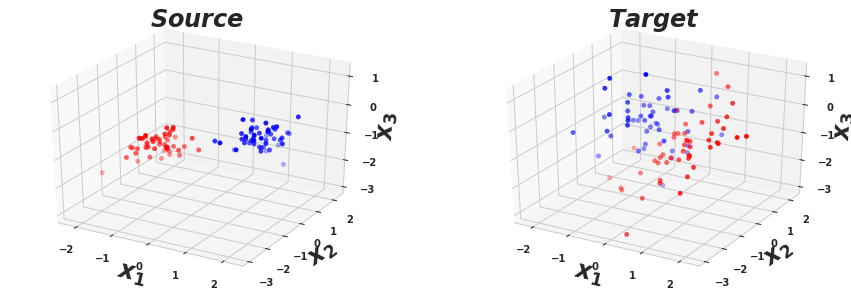

In [16]:
# Visualize data

fig = plt.figure(figsize=(15,5))

if D == 2:
        
    ax0 = fig.add_subplot(121)
    
    ax0.set_xlim([-4,4])
    ax0.set_ylim([-4,4])
    
    ax0.scatter(X[Y == 0, 0], X[Y == 0, 1], c='r')
    ax0.scatter(X[Y == 1, 0], X[Y == 1, 1], c='b')
    ax0.set_xlabel('$x_1$', fontsize=fS)
    ax0.set_ylabel('$x_2$', fontsize=fS)
    ax0.set_title('$Source$', fontsize=fS)

    ax1 = fig.add_subplot(122, sharex=ax0, sharey=ax0)
    ax1.scatter(Z[U == 0, 0], Z[U == 0, 1], c='r')
    ax1.scatter(Z[U == 1, 0], Z[U == 1, 1], c='b')
    ax1.set_xlabel('$x_1$', fontsize=fS)
    ax1.set_ylabel('$x_2$', fontsize=fS)
    ax1.set_title('$Target$', fontsize=fS);

elif D == 3:

    ax0 = fig.add_subplot(121, projection='3d')

    ax0.scatter(X[Y == 0, 0], X[Y == 0, 1], X[Y == 0, 2], c='r')
    ax0.scatter(X[Y == 1, 0], X[Y == 1, 1], X[Y == 0, 2], c='b')
    ax0.set_xlabel('$x_1$', fontsize=fS)
    ax0.set_ylabel('$x_2$', fontsize=fS)
    ax0.set_zlabel('$x_3$', fontsize=fS)
    ax0.set_title('$Source$', fontsize=fS)

    ax1 = fig.add_subplot(122, sharex=ax0, sharey=ax0, sharez=ax0, projection='3d')
    ax1.scatter(Z[U == 0, 0], Z[U == 0, 1], Z[U == 0, 1], c='r')
    ax1.scatter(Z[U == 1, 0], Z[U == 1, 1], Z[U == 0, 1], c='b')
    ax1.set_xlabel('$x_1$', fontsize=fS)
    ax1.set_ylabel('$x_2$', fontsize=fS)
    ax1.set_zlabel('$x_3$', fontsize=fS)
    ax1.set_title('$Target$', fontsize=fS)
    
fig.savefig('viz/2DG_problem-setting.png', bbox_inches='tight', padding=None)

In [17]:
# Domain means
muX = np.mean(X, axis=0)[:, np.newaxis].T
muZ = np.mean(Z, axis=0)[:, np.newaxis].T

# Centered data
X_ = X - muX
Z_ = Z - muZ

# Estimate principal components manually
aX, CX = alg.eig(np.cov(X_.T))
aZ, CZ = alg.eig(np.cov(Z_.T))

# Sort components on decreasing eigenvalues
ixX = np.argsort(aX)[::-1]
CX = CX[ixX,:]
ixZ = np.argsort(aZ)[::-1]
CZ = CZ[ixZ,:]

In [18]:
'''Find transformation'''

# Optimal linear transformation matrix
V = CX.T @ CZ

# Map source data onto source principal components
XC = X @ CX

# Map source data onto source principal components and align to target components
XV = X @ CX @ V

# Map target data onto target principal components
ZC = X @ CZ

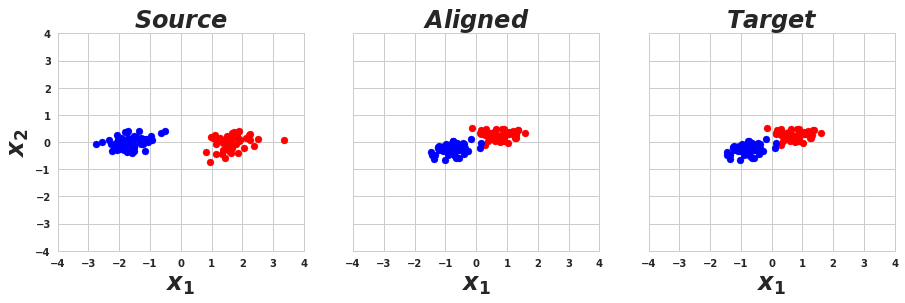

In [19]:
# Visualize data

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,4))

ax[0].set_xlim([-4,4])
ax[0].set_ylim([-4,4])

ax[0].scatter(XC[Y == 0, 0], XC[Y == 0, 1], c='r')
ax[0].scatter(XC[Y == 1, 0], XC[Y == 1, 1], c='b')
ax[0].set_xlabel('$x_1$', fontsize=fS)
ax[0].set_ylabel('$x_2$', fontsize=fS)
ax[0].set_title('$Source$', fontsize=fS)

ax[1].scatter(XV[Y == 0, 0], XV[Y == 0, 1], c='r')
ax[1].scatter(XV[Y == 1, 0], XV[Y == 1, 1], c='b')
ax[1].set_xlabel('$x_1$', fontsize=fS)
ax[1].set_title('$Aligned$', fontsize=fS);

ax[2].scatter(ZC[U == 0, 0], ZC[U == 0, 1], c='r')
ax[2].scatter(ZC[U == 1, 0], ZC[U == 1, 1], c='b')
ax[2].set_xlabel('$x_1$', fontsize=fS)
ax[2].set_title('$Target$', fontsize=fS);

fig.savefig('viz/2DG_subalign.png', bbox_inches='tight', padding=None)

Unsupervised Subspace Alignment matches components, not classes. So, it could be that the classes are flipped. 

That's also why I think it's a good idea to be working with the semi-supervised variant.

### All target labels

In [20]:
# Estimate class-specific components

muXk = np.zeros((K, D))
muZk = np.zeros((K, D))
CXk = np.zeros((K, D, D))
CZk = np.zeros((K, D, D))
Vk = np.zeros((K, D, D))

for k in range(K):
    
    # Extract source data from k-th class
    Xk = X[Y == k, :]
    muXk[k,:] = np.mean(Xk, axis=0)[:,np.newaxis].T
    
    # Extract target data from k-th class
    Zk = Z[U == k, :]
    muZk[k,:] = np.mean(Zk, axis=0)[:,np.newaxis].T
    
    # Extract source class-specific components
    aXk, CXk[k] = alg.eig(np.cov((Xk - muXk[k,:]).T))
    
    # Extract target class-specific components
    aZk, CZk[k] = alg.eig(np.cov((Zk - muZk[k,:]).T))
    
    # Find specific linear transformation matrix
    Vk[k] = CXk[k].T @ CZk[k]

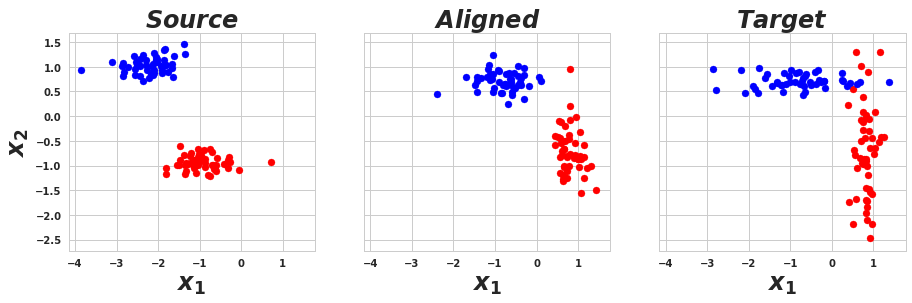

In [21]:
# Visualize data

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,4))

XC0 = (X[Y == 0, :] - muXk[0,:]) @ CXk[0] + muXk[0,:]
XC1 = (X[Y == 0, :] - muXk[1,:]) @ CXk[1] + muXk[1,:]

XV0 = (X[Y == 0, :] - muXk[0,:]) @ CXk[0] @ Vk[0] + muZk[0,:]
XV1 = (X[Y == 0, :] - muXk[0,:]) @ CXk[0] @ Vk[1] + muZk[1,:]

ZC0 = (Z[U == 0, :] - muZk[0,:]) @ CZk[0] + muZk[0,:]
ZC1 = (Z[U == 1, :] - muZk[1,:]) @ CZk[1] + muZk[1,:]

ax[0].scatter(XC0[:, 0], XC0[:, 1], c='r')
ax[0].scatter(XC1[:, 0], XC1[:, 1], c='b')
ax[0].set_xlabel('$x_1$', fontsize=fS)
ax[0].set_ylabel('$x_2$', fontsize=fS)
ax[0].set_title('$Source$', fontsize=fS)

ax[1].scatter(XV0[:, 0], XV0[:, 1], c='r')
ax[1].scatter(XV1[:, 0], XV1[:, 1], c='b')
ax[1].set_xlabel('$x_1$', fontsize=fS)
ax[1].set_title('$Aligned$', fontsize=fS);

ax[2].scatter(ZC0[:, 0], ZC0[:, 1], c='r')
ax[2].scatter(ZC1[:, 0], ZC1[:, 1], c='b')
ax[2].set_xlabel('$x_1$', fontsize=fS)
ax[2].set_title('$Target$', fontsize=fS);

fig.savefig('viz/2DG_semisubalign_all.png', bbox_inches='tight', padding=None)

The semi-supervised variant matches classes as well.

### 1 target label per class

In [22]:
# Select samples to be labeled
u = np.zeros((K, 2), dtype='uint8')

ix = rnd.choice(np.arange(M), size=1, p=(U==0)/np.sum(U==0))
u[0, 0] = ix
u[0, 1] = U[ix] 
                
ix = rnd.choice(np.arange(M), size=1, p=(U==1)/np.sum(U==0))
u[1, 0] = ix
u[1, 1] = U[ix] 

In [23]:
'''Find transformation'''

# Call instance of subalign
clf = SemiSubspaceAlignedClassifier()

# Obtain transformation matrix and components
V, CX, CZ = clf.semi_subspace_alignment(X, Y, Z, u, subspace_dim=d)

XC = np.zeros((N, d))
XV = np.zeros((N, d))

# Map target data onto target principal components
ZC = Z @ CZ

# Align each class
for k in range(K):
    
    # Mean
    muXk = np.mean(X[Y == k, :], axis=0, keepdims=1)

    # Map source data onto source principal components
    XC[Y == k, :] = (X[Y == k, :] - muXk) @ CX[k] + muXk @ CX[k]
    
    # Map source data onto source principal components and align to target components
    XV[Y == k, :] = (X[Y == k, :] - muXk) @ CX[k] @ V[k] + ZC[u[k,0], :]

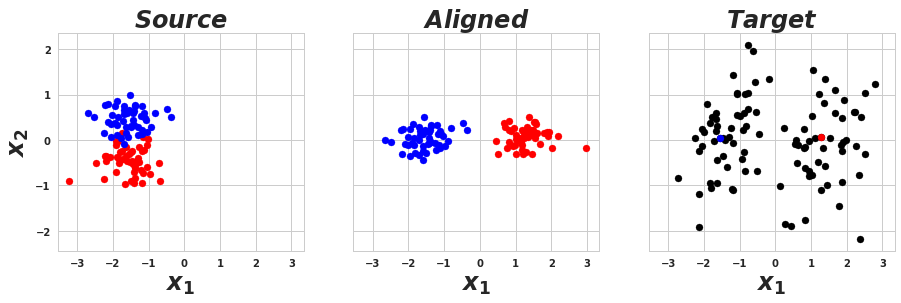

In [24]:
# Visualize data

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,4))

XC0 = XC[Y == 0, :]
XC1 = XC[Y == 1, :]
XV0 = XV[Y == 0, :]
XV1 = XV[Y == 1, :]
ZC0 = ZC[Y == 0, :]
ZC1 = ZC[Y == 1, :]

ax[0].scatter(XC0[:, 0], XC0[:, 1], c='r')
ax[0].scatter(XC1[:, 0], XC1[:, 1], c='b')
ax[0].set_xlabel('$x_1$', fontsize=fS)
ax[0].set_ylabel('$x_2$', fontsize=fS)
ax[0].set_title('$Source$', fontsize=fS)

ax[1].scatter(XV0[:, 0], XV0[:, 1], c='r')
ax[1].scatter(XV1[:, 0], XV1[:, 1], c='b')
ax[1].set_xlabel('$x_1$', fontsize=fS)
ax[1].set_title('$Aligned$', fontsize=fS);

ax[2].scatter(ZC[:, 0], ZC[:, 1], c='k')
ax[2].scatter(ZC[u[0,0], 0], ZC[u[0,0], 1], c='r')
ax[2].scatter(ZC[u[1,0], 0], ZC[u[1,0], 1], c='b')
ax[2].set_xlabel('$x_1$', fontsize=fS)
ax[2].set_title('$Target$', fontsize=fS);

fig.savefig('viz/2DG_semisubalign_one.png', bbox_inches='tight', padding=None)

The source classes are now matched to the target classes.